# Calculating and saving all metrics

_Alex I. Malz (GCCL@RUB) & Emille Ishida (LPC@Clermont-Ferrand)_

In [1]:
import pandas as pd
import matplotlib.pylab as plt
# import seaborn as sns
import numpy as np
import os

import gzip
import scipy.stats as sps
import sys

## data preprocessing

class naming scheme

In [2]:
# types_names = {90:'Ia', 67: '91bg', 52:'Iax', 42:'II', 62:'Ibc', 
#                95: 'SLSN', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf',
#                16:'EB',53:'Mira', 6:'MicroL', 991:'MicroLB', 992:'ILOT', 
#                993:'CART', 994:'PISN',995:'MLString'}

# SNANA_types = {90:11, 62:{1:3, 2:13}, 42:{1:2, 2:12, 3:14},
#                67:41, 52:43, 64:51, 95:60, 994:61, 992:62,
#                993:63, 15:64, 88:70, 92:80, 65:81, 16:83,
#                53:84, 991:90, 6:{1:91, 2:93}}

SNANA_names = {11: 'Ia', 3:'Ibc', 13: 'Ibc', 2:'II', 12:'II', 14:'II',
               41: '91bg', 43:'Iax', 51:'KN', 60:'SLSN', 61:'PISN', 62:'ILOT',
               63:'CART', 64:'TDE', 70:'AGN', 80:'RRL', 81:'M-dwarf', 83:'EB',
               84:'Mira', 90:'MicroLB', 91:'MicroL', 93:'MicroL'}

how to name saved files

In [3]:
# these are for what to name saved files
alex = False
redo = True

which test cas to run (because one big loop would be awful, although this should really be a script that runs them in parallel)

In [4]:
k = ''
field = 'DDF'
if field == 'WFD':
    k = '1'

manually remove cases that won't be in the same big plot

In [5]:
if field == 'DDF':
        dirname = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/emille_samples/'
        cases = os.listdir(dirname)
        cases.remove('random1500.csv')
        cases.remove('random6000.csv')
        cases.remove('fiducial1500.csv')
        cases.remove('fiducial6000.csv')
        cases.remove('perfect6000.csv')
        cases.remove('perfect1500.csv')
        cases.remove('all_DDF.csv')
        cases.remove('perfect3000.csv')
        cases.remove('random3000.csv')
elif field == 'WFD':
        dirname = '/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/emille_samples' + str(k) + '/'
        cases = os.listdir(dirname)
#         print(cases)
        cases.remove('M0DIF')
        cases.remove('fitres')
        cases.remove('stan_summary')
#         cases.remove('perfect1500.csv')
#         cases.remove('perfect6000.csv')
#         cases.remove('perfect3000_IX.csv')
#         cases.remove('perfect3000_I.csv') 
#         cases.remove('perfect3000_II.csv')
#         cases.remove('perfect3000_III.csv')
#         cases.remove('perfect3000_IV.csv')
#         cases.remove('perfect3000_V.csv')
#         cases.remove('perfect3000_VI.csv')
#         cases.remove('perfect3000_VII.csv')
#         cases.remove('perfect3000_VIII.csv')
#         cases.remove('perfect3000_0.csv')
        cases.remove('perfect3000.csv')
        cases.remove('random3000.csv')
        cases.remove('fiducial3000.csv')
if '.ipynb_checkpoints' in cases:
        cases.remove('.ipynb_checkpoints')

checking percentages matching names

In [6]:
# for name in cases:    
#     fname = dirname + name 

#     data = pd.read_csv(fname)

#     types, freq = np.unique(data['SIM_TYPE_INDEX'].values, return_counts=True)
        
# #     print('\n')
# #     print('case: ' + name)
# #     for i in range(len(types)):
# #         print('perc ' + SNANA_names[types[i]] + ' : ', round(freq[i]/data.shape[0], 2))
# #     print('Total number: ', data.shape[0])
# #     print('Unique ids: ', np.unique(data['CID'].shape[0]))
# #     print('\n')

## how to calculate classification metrics

In [7]:
import proclam
from proclam.metrics.util import *
from proclam.metrics.util import RateMatrix

class for binary classification metrics

TODO: add in checks for between 0 and 1

TODO: put this in proclam

In [8]:
class det_mets(RateMatrix):
    "binary classification metrics"
    def __init__(self, **rates):
        """
        Call like `thing = det_mets(**rates._asdict())`
        """
#         self.rates = rates#.asdict()
        self._get_tots()
        self._from_rates()
        self._sn_mets()
        self._translate()
    def _get_tots(self):
        self.CP = self.TP + self.FN
        self.CN = self.TN + self.FP
        self.T = self.TP + self.TN
        self.F = self.FP + self.FN
        self.P = self.TP + self.FP
        self.N = self.TN + self.FN
    def _from_rates(self):
        self.PPV = self.TP / (self.TP + self.FP)
        self.NPV = self.TN / (self.TN + self.FN)
        self.PT = (np.sqrt(self.TPR * (1. - self.TNR)) + self.TNR - 1.) / (self.TPR + self.TNR - 1.)
        self.TS = self.TP / (self.TP + self.FN + self.FP)
        self._derived()
    def _derived(self):
        self.ACC = (self.TP + self.TN) / (self.CP + self.CN)
        self.BA = (self.TPR + self.TNR) / 2.,
        self.F1S = 2. * self.PPV * self.TPR / (self.PPV + self.TPR)
        self.MCC = (self.TP * self.TN - self.FP * self.FN) / (np.sqrt(self.P * self.CP * self.CN * self.N))
        self.FM = np.sqrt(self.PPV * self.TPR)
        self.BM = self.TPR + self.TNR - 1.
        self.MK = self.PPV + self.NPV - 1.
    def _translate(self):
        self.positive = self.CP
        self.negative = self.CN
        self.sensitivity = self.TPR
        self.recall = self.TPR
        self.specificity = self.TNR
        self.selectivity = self.TNR
        self.precision = self.PPV
        self.FDR = 1. - self.PPV
        self.FOR = 1. - self.NPV
        self.CSI = self.TS
        self.accuracy = self.ACC
        self.f1_score = self.F1S
        self.informedness = self.BM
        self.deltaP = self.MK
    def _sn_mets(self):
        self.get_efficiency()
        self.get_purity()
    def get_efficiency(self):
        self.efficiency = self.TP / self.CP
        return self.efficiency
    def get_purity(self):
        self.purity = self.TP / self.P
        return self.purity
    def get_fom(self, penalty):
        self.pseudo_purity = self.TP / (self.TP + penalty * self.FP)
        fom = self.pseudo_purity * self.efficiency
        return fom
    

make the proclam ratematrix from information we know about each test case

In [9]:
def nums_to_rate(tot, P, T, FP):
    N = tot - P
    TN = N - FP
    F = tot - T
    FN = F - TN
    TP = P - FN
    assert(FP + FN + TP + TN == tot)
    
    TPR = TP / P
    FPR = FP / N
    FNR = FN / P
    TNR = TN / N
    
#     cm = np.array([[totIa - cont, totall - ], [, cont]])
    rate = proclam.util.RateMatrix(TPR=TPR, FPR=FPR, FNR=FNR, TNR=TNR, TP=TP, FN=FN, TN=TN, FP=FP)
    return rate

define the true number of objects available in each sample before and after SALT2 fit as filter

In [10]:
total = {}
total['DDF'] = {}                     # total number of objects in the sample
total['DDF']['before_salt2'] = 4335
total['DDF']['after_salt2'] = 3456
total['WFD'] = {}
total['WFD']['before_salt2'] = 5588
total['WFD']['after_salt2'] = 3306

calculate the metrics from the available numbers of objects

In [11]:
def classification_metrics(cont, totIa=3000, before_salt2=False, field=field):
    """Classification metrics for a sample of 3k SNIa.
    
    Parameters
    ----------
    cont: int < totIa
        number of contaminant objects
    totIa: int (optional)
        Number of Ia in the sample. Default is 3000.
    before_salt2: bool (optional)
        If True use total sample number before SALT2 fit.
        Default is False.
    field: str (optional)
        Cadence: 'DDF' or 'WFD'. Default is DDF.
        
    Returns
    -------
    accuracy: floatTPR=TPR, FPR=FPR, FNR=FNR, TNR=TNR, TP=TP, FN=FN, TN=TN, FP=FP
    efficiency: float
    purity: float
    figure of merit (W=1): float
    figure of merit (W=3): float
    """
    
    if totIa != 3000:
        raise ValueError('Numbers are hard coded for 3000 SNIa.')
#         return(np.nan, np.nan, np.nan, np.nan, np.nan)
    
    if before_salt2:
        totall = total[field]['before_salt2']
    else:
        totall = total[field]['after_salt2']
    
    rate = nums_to_rate(tot=totall, P=totIa, T=totIa, FP=cont)._asdict()
    class_mets = det_mets(**rate)
    
#     acc = (totall - (2* totIa * cont))/totall
#     eff = (totIa - totIa * cont)/totIa
#     f1 = ((totIa - totIa * cont)/totIa) * (1 - cont)
#     c = float(cont) / float(totIa)
#     f3 = ((1. - c) * totIa)/(((1. - c) * totIa) + 3. * ((c) * totIa))
    f3 = class_mets.get_fom(3.)
#     if f3 < 0. or f3 > 1.:
#         return False
    
#     return acc, eff, 1 - cont, f1, f3
    return class_mets.accuracy, class_mets.get_efficiency(), class_mets.get_purity(), class_mets.f1_score, f3#class_mets.get_fom(3.)

## how to calculate KLD

KLD is prone to numerical divergence when coverage between distributions is poor, so protect against overflow/underflow

In [12]:
eps = 2. * sys.float_info.min

def safe_log(arr, threshold=eps):
    """
    Takes the natural logarithm of an array that might contain zeros.

    Parameters
    ----------
    arr: ndarray, float
        array of values to be logged
    threshold: float, optional
        small, positive value to replace zeros and negative numbers

    Returns
    -------
    logged: ndarray
        logged values, with small value replacing un-loggable values
    """
    arr = np.asarray(arr)
    arr[arr < threshold] = threshold
    logged = np.log(arr)
    return logged

how to make a grid and fit multidimensional KDE to posterior samples

In [13]:
def make_grid(x, y, x_ngrid=100, y_ngrid=100):
    x_min = x.min()#-1.2
    x_max = x.max()#-0.8
    y_min = y.min()#0.2
    y_max = y.max()#0.4

    x_grid, y_grid = np.mgrid[x_min:x_max:x_ngrid*1.j, y_min:y_max:y_ngrid*1.j]
    x_vec, y_vec = x_grid[:, 0], y_grid[0, :]
    dx = (x_max - x_min) / (x_ngrid - 1)
    dy = (y_max - y_min) / (y_ngrid - 1)

    return(((x_min, y_min), (x_max, y_max)), (x_grid, y_grid), (x_vec, y_vec), (dx, dy))

def make_kde(Xgrid, Ygrid, Xsamps, Ysamps, to_log=False, save=None):
    positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
    values = np.vstack([Xsamps, Ysamps])
    kernel = sps.gaussian_kde(values, bw_method='scott')
    Z = np.reshape(kernel(positions).T, Xgrid.shape)
    if to_log:
        return safe_log(Z)
    else:
        return Z
    
#     if save is not None:
        
# TODO: normalize up here before log!

use chippr implementation of KLD

In [14]:
# stolen from chippr
def calculate_kld(lpe, lqe, dx, from_log=False, vb=True):
    """
    Calculates the Kullback-Leibler Divergence between two N-dimensional PDFs 
    evaluated on a shared, regular grid (sorry, too lazy to deal with irregular grid)

    Parameters
    ----------
    lpe: numpy.ndarray, float
        log-probability distribution evaluated on a grid whose distance from `q`
        will be calculated.
    lqe: numpy.ndarray, float
        log-probability distribution evaluated on a grid whose distance to `p` will
        be calculated.
    dx: numpy.ndarray, float
        separation of grid values in each dimension
    from_log: boolean, optional
        if False, lpe, lqe are probability distributions, not log-probability distributions
    vb: boolean, optional
        report on progress to stdout?

    Returns
    -------
    Dpq: float
        the value of the Kullback-Leibler Divergence from `q` to `p`
    """
    # Normalize the evaluations, so that the integrals can be done
    gridnorm = np.ones_like(lpe) * np.prod(dx)
    if from_log:
        pe = np.exp(lpe)
        qe = np.exp(lqe)
#     print(np.prod(dx))
#     print(gridnorm)
    else:
        pe = lpe
        qe = lqe
    pi = np.sum(pe * gridnorm)
    qi = np.sum(qe * gridnorm)
    # (very approximately!) by simple summation:
    pn = pe / pi
    qn = qe / qi
    # Compute the log of the normalized PDFs
    logp = safe_log(pn)
    logq = safe_log(qn)
    # Calculate the KLD from q to p
    Dpq = np.sum(pn * (logp - logq))
#     if np.isnan(Dpq):
#         return((lpe, lqe, dx))
    return Dpq

## Prep for the metrics calculations

set up for saving the metrics

In [15]:
names = []

pop_Ia_all = []
pop_nIa_all = []
perc_Ia_all = []
perc_nIa_all = []

wfit_w_all = []
wfit_wsig_all = []
wfit_om_all = []
wfit_omsig_all = []
wfit_w_all_lowz = []
wfit_wsig_all_lowz = []
wfit_om_all_lowz = []
wfit_omsig_all_lowz = []

stan_w_all = []
stan_wsig_all = []
stan_om_all = []
stan_omsig_all = []

stan_w_all_lowz = []
stan_wsig_all_lowz = []
stan_om_all_lowz = []
stan_omsig_all_lowz = []

other_index = []
other_name = []

wdist_median = []

eff = []
pur = []
acc = []
f1 = []
f3 = []

read Wasserstein distances

In [16]:
if field == 'DDF':
    fname = 'Wasserstein/wassersteinDistances_ddf.dat'
elif field == 'WFD':
    fname = 'Wasserstein/wassersteinDistances_wfd' + str(k) +'.dat'

wdist = pd.read_csv(fname)
name_flagA = np.array(['perfect3000' in name for name in wdist['FileA'].values])
name_flagB = np.array(['perfect3000' in name for name in wdist['FileB'].values])
name_flag = np.logical_or(name_flagA, name_flagB)

if field == 'DDF':
    wdist_ddf = wdist[name_flag]
elif field == 'WFD':
    wdist_wfd = wdist[name_flag]

prep KDE for reference (closest to truth) distribution

In [17]:
path_pre = dirname[:46]
path_post = 'posteriors/samples_emille'+str(k)+'/'
refname = 'chains_perfect3000_lowz_withbias.csv.gz'

# fieldstr = {'DDF': 'ddf', 'WFD': 'wfd'}

fullpath = path_pre + path_post
alloutputs = pd.DataFrame(columns=['path', 'KLD'])
    # make reference sample
with gzip.open(fullpath+refname) as reffn:
    flatref = pd.read_csv(reffn)
[w_ref, Omm_ref] = [flatref['w'], flatref['om']]
ref_extrema, ref_grids, ref_vecs, ref_ds = make_grid(w_ref, Omm_ref)
(w_vec, Omm_vec) = ref_vecs
(dw, dOmm) = ref_ds
((xmin, ymin), (xmax, ymax)) = ref_extrema
(w_grid, Omm_grid) = ref_grids
d_ref = {'w': dw, 'Omm': dOmm}
grid_ref = {'w': w_grid, 'Omm': Omm_grid}
kde_ref = make_kde(w_grid, Omm_grid, w_ref, Omm_ref)

diagnostic plots for the posterior samples

TODO: check that $\Omega_{m}$ dimension is the same for all cases (and flat?)

TODO: check for coverage

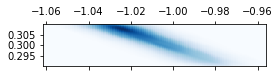

In [36]:
# hist_perf, xgrid, ygrid = np.histogram2d(w_ref, Omm_ref, bins=ref_vecs, density=True)
# plt.imshow(kde_ref.T, origin='lower', extent=[xmin, xmax, ymin, ymax], cmap=plt.cm.Blues)

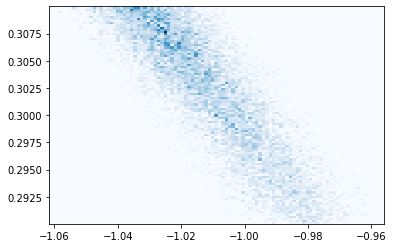

In [19]:
# plt.hist2d(w_ref, Omm_ref, bins=[w_vec, Omm_vec], density=True, cmap=plt.cm.Blues)
# plt.savefig('just_dist.png')

In [61]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# stolen from chippr
def fancyplot(xdata, ydata, xgrid, ygrid, xlab='', ylab='', title=''):
    # 2d KDE
    f, scatplot = plt.subplots(figsize=(7.5, 7.5))
    f.subplots_adjust(hspace=0)
#     plt.scatter(points['redshift'], points['"data"'], marker='.', s=2, color='k')
#     Z = Z.reshape(X.shape)
    scatplot.hist2d(xdata, ydata, bins=[xgrid, ygrid], alpha=0.5, density=True, cmap=plt.cm.Blues)
    
#     scatplot.contourf(xgrid, ygrid, data, alpha=0.75, linestyles=None)# scatplot.colorbar()
#     plt.plot([0, 4.25], [0, 4.25], color=discrete_colors[-1], alpha=1.)
#     scatplot.vlines(3., 0., 4.25, linewidth=10., alpha=0.5, color=col_hor)
#     scatplot.hlines(2., 0., 4.25, linewidth=10., alpha=0.5, color=col_ver)
    scatplot.set_xlabel(xlab, fontsize=20)
    scatplot.set_ylabel(ylab, fontsize=20)
#     if lims != None:
#     scatplot.set_xlim(0., 4.25)
#     scatplot.set_ylim(0., 4.25)
#     scatplot.set_yticks([])#0., 1., 2., 3., 4])
#     scatplot.set_xticks([0., 1., 2., 3., 4])
    divider = make_axes_locatable(scatplot)
    histx = divider.append_axes('top', 1.2, pad=0., sharex=scatplot)
    histy = divider.append_axes('right', 1.2, pad=0., sharey=scatplot)
    histx.xaxis.set_tick_params(labelbottom=False)
    histy.yaxis.set_tick_params(labelleft=False)
    histx.hist(xdata, bins=xgrid, alpha=0.75, density=True)
    histy.hist(ydata, bins=ygrid, alpha=0.75, density=True, orientation='horizontal')
    histx.set_yticks([])
# histx.set_xlim(0., 4.25)
    histy.set_xticks([])
# histy.set_ylim(0., 4.25)
# histx.text(0.5, 1.25, r'posterior\\$p(z\mid \mathrm{``data"})$', rotation=0, size=16)
# histy.text(0.85, 2., r'likelihood\\$p(\mathrm{``data"}\mid z)$', rotation=-90, size=16)
# f.savefig('jain15.png', bbox_inches='tight', pad_inches=0, dpi=250)
    scatplot.set_title(title, fontsize=24)
    f.show()

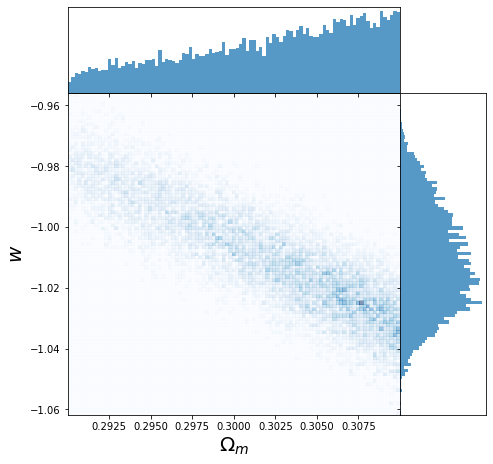

In [62]:
fancyplot(Omm_ref, w_ref, Omm_vec, w_vec, xlab=r'$\Omega_{m}$', ylab=r'$w$')

## read in cosmology outputs and calculate classification metrics

In [ ]:
for case in cases:

    names.append(case[:-4])
    
    pop = {}
    perc = {}

    samples_dir = case[:-4] + '/'
    
    if field == 'DDF':
        if alex:
            data = pd.read_csv('/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/' +\
                           'resspect_metric/SALT2_fit/DDF_Alex/' + case)
        else:
            data = pd.read_csv(dirname + case)
    else:
        data = pd.read_csv(dirname + case)
#     elif field == 'WFD':
#         data = pd.read_csv('/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/emille_samples' + str(k) + '/' + case)
            
    stats = np.unique(data['SIM_TYPE_INDEX'].values, return_counts=True)
    
    if field == 'DDF':
        if alex:
            fname_cosmo_lowz = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/' + \
                    'posteriors/DDF/' + case[:-4] + '/' + \
                    'Alex_samples/omprior_0.01_flat/results/test_salt2mu_lowz_withbias_' + case[:-4] + '.M0DIF.cospar'
        else:
            fname_cosmo_lowz = \
                      '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/M0DIF/omprior_0.01_flat/' + \
                     'test_salt2mu_lowz_withbias_' + case[:-4] + '.M0DIF.cospar'
    elif field == 'WFD':
        fname_cosmo_lowz = '/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/emille_samples' + str(k) + '/M0DIF/' \
                        + '/test_salt2mu_lowz_withbias_' + case[:-4] + '.M0DIF.cospar'
        
    cosmofit_lowz = pd.read_csv(fname_cosmo_lowz, delim_whitespace=True,
                          comment='#', names=['w', 'wsig_marg',  'OM',  'OM_sig',  'chi2',  
                                              'Ndof',  'sigint', 'wran',  'OMran',  'label'])
    wfit_w_all_lowz.append(cosmofit_lowz['w'].values[0])
    wfit_wsig_all_lowz.append(cosmofit_lowz['wsig_marg'].values[0])
    wfit_om_all_lowz.append(cosmofit_lowz['OM'].values[0])
    wfit_omsig_all_lowz.append(cosmofit_lowz['OM_sig'].values[0])

    if field == 'DDF':
        if alex:
            fname_stan = case[:-4] + '/Alex_samples/omprior_0.01_flat/results/stan_summary_' + case[:-4] + '_lowz_withbias.dat'
        else:
            fname_stan = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/stan_summary/omprior_0.01_flat/stan_summary_' + \
                      case[:-4] + '_lowz_withbias.dat'
    elif field == 'WFD':
        fname_stan = '/media/RESSPECT/data/PLAsTiCC/for_metrics/wfd/emille_samples' + str(k) + '/stan_summary/' \
                 + 'stan_summary_' + case[:-4] + '_lowz_withbias.dat'

    
    op2 = open(fname_stan, 'r')
    lin2 = op2.readlines()
    op2.close()
    
    for j in range(len(lin2)):
        if lin2[j][:2] == 'om':
            om = lin2[j].split()[1]
            omsig = lin2[j].split()[3]
            stan_om_all_lowz.append(om)
            stan_omsig_all_lowz.append(omsig)
            
            #print('om = ', om)
            #print('omsig = ', omsig)
            
            
        elif lin2[j][0] == 'w':
            w = lin2[j].split()[1]
            wsig = lin2[j].split()[3]
            stan_w_all_lowz.append(w)
            stan_wsig_all_lowz.append(wsig)
            
    # classification metrics
            
    Ia_code = 11
        
    flag_Ia = np.array(stats[0]) == Ia_code
    
    pop[Ia_code] = stats[1][flag_Ia][0]
    perc[Ia_code] = round(100 * stats[1][flag_Ia][0]/data.shape[0])
    
    if  len(stats[0]) == 2:
        other_code = [item for item in stats[0] if item != Ia_code][0]
        pop[other_code] = stats[1][~flag_Ia][0]
        perc[other_code] = 100 * stats[1][~flag_Ia][0]/data.shape[0]
            
        pop_nIa_all.append(pop[other_code])
        perc_nIa_all.append(perc[other_code])
        other_index.append(other_code)
        other_name.append(SNANA_names[other_code])
        
    elif len(stats[0]) > 2:
        other_code = [item for item in stats[0] if item != Ia_code]
        for item in range(flag_Ia.shape[0]):
            if not flag_Ia[item]:
                pop[stats[0][item]] = stats[1][item]
                perc[stats[0][item]] = round(100 * stats[1][item]/data.shape[0])
                
        pop_nIa_all.append([pop[item] for item in other_code])
        perc_nIa_all.append([perc[item] for item in other_code])
        other_index.append(other_code)
        other_name.append([SNANA_names[i] for i in other_code])
        
    elif len(stats[0]) == 1:
        other_code = '--'
        pop_nIa_all.append(None)
        perc_nIa_all.append(None)
        other_index.append(None)
        other_name.append(None)

    pop_Ia_all.append(pop[Ia_code])
    perc_Ia_all.append(perc[Ia_code])
    
    
#     if '6' in case:
#         tot = 6000
#     elif '5' in case:
#         tot = 1500
#     elif '1000' in case:
#         tot = 1000
#     else:
    tot = 3000
    
# this is where number of contaminants gets converted to fraction
    cont = tot - pop[Ia_code]
    
    if field == 'DDF':
        for i in range(wdist_ddf.shape[0]):
            if case[:-4] in wdist_ddf['FileA'].values[i] or \
                case[:-4] in wdist_ddf['FileB'].values[i]:
                wdist_median.append(wdist_ddf['WassersteinDistanceMedian'].values[i])
                break
    elif field == 'WFD':
        if k in [1, '', 2, 3,4,5]:
            for i in range(wdist_wfd.shape[0]):
                if case[:-4] in wdist_wfd['FileA'].values[i] or \
                    case[:-4] in wdist_wfd['FileB'].values[i]:
                    wdist_median.append(wdist_wfd['WassersteinDistanceMedian'].values[i])
                    break
        else:
            wdist_median.append(-99)
    
    if tot == 3000:
        metrics = classification_metrics(cont)
    else: 
        print((cont, case))
        metrics = [np.nan, np.nan, np.nan, np.nan, np.nan]
    if not metrics:
        print((cont, case))
    acc.append(metrics[0])
    eff.append(metrics[1])
    pur.append(metrics[2])
    f1.append(metrics[3])
    f3.append(metrics[4])
        
data_all = {}
data_all['case'] = names
data_all['other_name'] = other_name
data_all['other_code'] = other_index
data_all['nIa'] = pop_Ia_all
data_all['nothers'] = pop_nIa_all
data_all['perc_Ia'] = perc_Ia_all
data_all['perc_others'] = perc_nIa_all
data_all['accuracy'] = acc
data_all['efficiency'] = eff
data_all['purity'] = pur
data_all['f1'] = f1
data_all['fom3'] = f3
data_all['wfit_w_lowz'] = wfit_w_all_lowz
data_all['wfit_wsig_lowz'] = wfit_wsig_all_lowz
data_all['wfit_om_lowz'] = wfit_om_all_lowz
data_all['wfit_omsig_lowz'] = wfit_omsig_all_lowz
data_all['stan_w_lowz'] = stan_w_all_lowz
data_all['stan_wsig_lowz'] = stan_wsig_all_lowz
data_all['stan_om_lowz'] = stan_om_all_lowz
data_all['stan_omsig_lowz'] = stan_omsig_all_lowz
data_all['WassersteinDistanceMedian'] = wdist_median

data_all = pd.DataFrame(data_all)

## calculate KLD 

This is the slowest step

TODO: add onto fancyplot overplotting each set of posteriors as contours (as in [chi

TODO: change to 1D posteriors in calculation, check that it doesn't affect ranking

In [ ]:
# # add KLD
# if True:
#     fname1 = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/posteriors/klds.csv'
#     data_kld_ddf = pd.read_csv(fname1)

#     kld_ddf_column = []
#     for i in range(data_all.shape[0]):
#         name = data_all.iloc[i]['case']
    
#         found = False
#         for j in range(data_kld_ddf.shape[0]):
#             if name in data_kld_ddf['path'].iloc[j]:
#                 kld = data_kld_ddf['KLD'].iloc[j]
#                 kld_ddf_column.append(kld)
#                 found = True
            
#         if not found:
#             kld_ddf_column.append(-99)
        
#     data_all['KLD'] = kld_ddf_column
# else:
#     data_all['KLD'] = -99

path_pre = dirname[:46]
path_post = 'posteriors/samples_emille'+str(k)+'/'
refname = 'chains_perfect3000_lowz_withbias.csv.gz'

# fieldstr = {'DDF': 'ddf', 'WFD': 'wfd'}

fullpath = path_pre + path_post

alloutputs = pd.DataFrame(columns=['case', 'KLD'])
for case in cases:
#     fullpath = dirname
    # make reference sample
    # make comparison samples
#     allfn = os.scandir(fullpath)
#     for entry in allfn:
#         if entry.is_file() and entry.name[-4:] != '.csv':
    samppath = fullpath+'chains_'+case[:-4]+'_lowz_withbias.csv.gz'
    with gzip.open(samppath) as sampfile:
        sampdata = pd.read_csv(sampfile)
        [w_comp, Omm_comp] = [sampdata['w'], sampdata['om']]
        kde_comp = make_kde(grid_ref['w'], grid_ref['Omm'], w_comp, Omm_comp)
        the_kld = calculate_kld(kde_ref, kde_comp, np.array([d_ref['w'], d_ref['Omm']]))
        newrow = {'case': case[:-4], 'KLD': the_kld}
        print((newrow, type(newrow['KLD'])))
        alloutputs = alloutputs.append(newrow, ignore_index=True)
#     if case[:-4] == '90SNIa10SNIax':
#         plt.hist2d(w_ref, Omm_ref, bins=[w_vec, Omm_vec], density=True, cmap=plt.cm.Blues, alpha=0.5)
#         plt.hist2d(w_comp, Omm_comp, bins=[w_vec, Omm_vec], density=True, cmap=plt.cm.Reds, alpha=0.5)
#         plt.show()
#         data_all[data_all['case'] == case]['KLD'] = the_kld
# alloutputs.to_csv(fullpath+'klds.csv')

### put it all together

In [ ]:
data_all = data_all.join(alloutputs.set_index('case'), on='case')

### save results!!!

In [ ]:
# if True:
if field == 'DDF':
    if alex:
        data_all.to_csv('summary_cases_omprior_0.01_flat_alex.csv', index=False)
        data_all.to_csv('/media2/RESSPECT2/data/posteriors_ddf/omprior_0.01_flat/summary_cases_alex.csv', index=False)
    elif redo:
        data_all.to_csv('summary_cases_omprior_0.01_flat_redone.csv', index=False)
        data_all.to_csv('/media2/RESSPECT2/data/posteriors_ddf/omprior_0.01_flat/summary_cases_redone.csv', index=False)
    else:
        data_all.to_csv('summary_cases_omprior_0.01_flat_emille.csv', index=False)
        data_all.to_csv('/media2/RESSPECT2/data/posteriors_ddf/omprior_0.01_flat/summary_cases_emille.csv', index=False)
elif field == 'WFD':
    if redo:
        data_all.to_csv('summary_cases_omprior_0.01_flat_redone' + str(k) +'.csv', index=False)
        data_all.to_csv('/media2/RESSPECT2/data/posteriors_wfd/omprior_0.01_flat/summary_cases_omprior_0.01_flat_redone' + \
                str(k) + '.csv', index=False)
    else:
        data_all.to_csv('summary_cases_omprior_0.01_flat_emille' + str(k) +'.csv', index=False)
        data_all.to_csv('/media2/RESSPECT2/data/posteriors_wfd/omprior_0.01_flat/summary_cases_omprior_0.01_flat_emille' + \
                str(k) + '.csv', index=False)

## plot results

see other notebooks

In [ ]:
# # sns.set(style='white')

# #c=perc_Ia
# #markershape=other_name

# plt.title('DDF')
# plt.scatter(data_all['fom3'], data_all['WassersteinDistanceMedian'], 
#             c=1.-data_all['perc_Ia'], marker='x', alpha=0.5)
# # plt.xlim(0.725, 1.025)
# plt.xlabel('fom', fontsize=20)
# plt.ylabel('Wasserstein Distance')
# plt.savefig('DDF_Wasserstein_v_FOM.png')
# plt.show()

In [ ]:
# plt.title('DDF')
# plt.scatter(data_all['fom3'], data_all['KLD'], 
#             c=1.-data_all['perc_Ia'], marker='x', alpha=0.5)
# plt.semilogy()
# # plt.xlim(0., 1.05)
# plt.xlabel('fom', fontsize=20)
# plt.ylabel('KLD')
# plt.savefig('DDF_KLD_v_FOM.png')
# plt.show()

In [ ]:
# plt.figure()
# plt.

In [ ]:
# plt.figure(figsize=(16,5))

# plt.subplot(1,2,1)
# plt.hist(data_all['stan_w_lowz'].values.astype(float), color='green', label='stan', alpha=0.5)
# plt.hist(data_all['wfit_w_lowz'].values.astype(float), color='brown', label='wfit', alpha=0.3)
# plt.xlabel('w', fontsize=14)
# plt.ylabel('N', fontsize=14)
# plt.legend()

# plt.subplot(1,2,2)
# plt.hist(data_all['stan_wsig_lowz'].values.astype(float), color='green', alpha=0.5, label='stan')
# plt.hist(data_all['wfit_wsig_lowz'].values.astype(float), color='brown', label='wfit', alpha=0.3)
# plt.xlabel('wsig_from_stan_with_lowz', fontsize=14)
# plt.ylabel('N', fontsize=14)
# plt.legend()

# plt.show()

In [ ]:
# from astropy.cosmology import FlatLambdaCDM
    
# cosmo = FlatLambdaCDM(H0=72, Om0=0.3)
# theor_dist = [cosmo.distmod(z).value for z in np.arange(0.001,1.5,0.005)]

# for name in cases[:2]:
    
#     fname_cosmo_lowz = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/M0DIF/omprior_0.01_flat/' + \
#                        'test_salt2mu_lowz_withbias_' + name[:-4] + '.M0DIF.cospar'
    
#     cosmofit = pd.read_csv(fname_cosmo_lowz, delim_whitespace=True,
#                           comment='#', names=['w', 'wsig_marg',  'OM',  'OM_sig',  'chi2',  
#                                               'Ndof',  'sigint', 'wran',  'OMran',  'label'])
    
#     fname_fitres = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/fitres/test_salt2mu_lowz_withbias_' + name[:-4] + '.fitres'
#     fitres = pd.read_csv(fname_fitres, comment='#', delim_whitespace=True)
    
#     flag = np.logical_or(fitres['SIM_TYPE_INDEX'].values == 11, fitres['SIM_TYPE_INDEX'].values == 1)
#     z = fitres['SIM_ZCMB'].values
#     mu = fitres['MU'].values
#     muerr = fitres['MUERR'].values
    
    
#     fig = plt.figure(figsize=(10,8))
        
#     ax = fig.add_subplot(111)
#     ax.set_title(name, fontsize=26)

#     if sum(flag) > 0:
#         plt.errorbar(z[flag], mu[flag], yerr=muerr[flag], fmt='o', alpha=0.1, label='spec-Ia', color='blue')
    
#     if sum(~flag) > 0:
#         plt.errorbar(z[~flag], mu[~flag], yerr=muerr[~flag], fmt='^', alpha=0.1, label='photo-Ia', color='green')
       
#     plt.plot(np.arange(0.001, 1.5,0.005), theor_dist, label='w = -1', color='red')

#     w = str(cosmofit['w'].values[0])
#     if len(w) >= 6:
#         w1 = w[:6]
#     else:
#         w1 = w.ljust(6, '0')
            
#     werr = str(cosmofit['wsig_marg'].values[0])
#     if len(werr) >= 6:
#         werr1 = werr[:5]
#     else:
#         werr1 = werr.ljust(5, '0')
            
#     flag_case = data_all['case'].values == name[:-4]
#     ax.text(0.2, 32, 'stan = ' + str(data_all[flag_case]['stan_w_lowz'].values[0]) + r' $\pm$ ' + \
#             str(data_all[flag_case]['stan_wsig_lowz'].values[0]), fontsize=20)
#     ax.text(0.2, 30, r'wfit = ' + w1 + r' $\pm$ ' + werr1 , fontsize=20)
        
#     ax.set_xlabel('redshift', fontsize=22)
#     ax.set_ylabel('mu', fontsize=22)
#     plt.legend(fontsize=22, loc='lower right')

    
#     #plt.savefig('plots/distances/omprior_0.01_flat/dist_' + name[:-4] + '.png')
#     #plt.close('all')

# Save samples for Alberto

## [Emille]: I would not consider the cell above because the only thing it does is to copy the files

all files are accessible at `/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/posteriors/samples_emille/`
